In [1]:
import plumed
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import MDAnalysis as md
from MDAnalysis.analysis import distances
import pandas as pd
import itertools
import random
from deeptime.decomposition import TICA
from deeptime.covariance import KoopmanWeightingEstimator
from deeptime.clustering import MiniBatchKMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import networkx as nx
from copy import deepcopy
from numpy.random import multinomial
import subprocess
import os
import math
import string
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
###############################USER DEFINE REGION##################################

### Hyperparameters
# Run setup
colvar = 'CV/COLVAR'
n_sim = 16
n_rounds = 20
sim_idx = 5
n_jobs = 32
# TICA parameters (for adaptive sampling)
tica_lagtime = 20
dim = None
var_cutoff = 0.95
koopman = True
# CV machine learning & convergence check
convergence_check = True
num_cvs = 2

### Analysis functions
def read_features(colvar,sim_idx,n_sim):
    # traj is the time-series COLVAR in pandas.DataFrame format
    traj_idx = []
    for i in range(sim_idx*n_sim):
        traj_idx.append(i)
    
    no_traj = len(traj_idx)
    traj = [0]*no_traj
    
    for i in traj_idx:
        traj[i] = plumed.read_as_pandas(colvar+'_{i}'.format(i=i))
        traj[i] = traj[i].drop(columns=['time'])
        columns = list(traj[i].columns.values)
        # Remove all dihedral angles, only keep sin/cos dihedrals 
        for column in columns:
            if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
                traj[i] = traj[i].drop(columns=[column])
            
    # data is the time-series COLVAR in numpy.ndarrays format
    data = [0]*len(traj)
    for i in range(len(traj)):
        numpy_data = traj[i].to_numpy(dtype='float32')
        data[i] = numpy_data
            
    return traj,data

def data_supplement(sim_idx,data,lagtime):
    round_seed_idx = []

    for i in range(1,sim_idx):
        round_seed_idx_i = np.loadtxt('round{i}_seed.txt'.format(i=i),dtype=int)
        round_seed_idx.append(round_seed_idx_i)

    round_seed_idx = np.concatenate(round_seed_idx)

    data_supp = []

    for i,round_seed_idx_i in enumerate(round_seed_idx):
    
        sim_i = round_seed_idx_i[0]
        frame = round_seed_idx_i[1]
    
        if frame == 0:
            continue
        elif lagtime > frame:
            start_frame = 0
        else:
            start_frame = frame - lagtime + 1
    
        end_frame = lagtime
    
        data_supp_pre = data[sim_i][start_frame:frame,:]
        data_supp_post = data[i][:end_frame,:]
        data_supp_i = np.concatenate([data_supp_pre,data_supp_post])
    
        data_supp.append(data_supp_i)
    
    return data_supp
    
def run_TICA(data,data_supp,lagtime,dim=None,var_cutoff=None,koopman=True):
    data_syn = data + data_supp
    tica = TICA(lagtime=lagtime,dim=dim,var_cutoff=var_cutoff)
    if koopman == True:
        koopman_estimator = KoopmanWeightingEstimator(lagtime=lagtime)
        reweighting_model = koopman_estimator.fit(data_syn).fetch_model()
        tica = tica.fit(data_syn, weights=reweighting_model).fetch_model()
    else:
        tica = tica.fit(data_syn).fetch_model()
    # tica is the data-fitted model, which contains eigenvalues and eigenvectors
    # tica_output is the tranformed time-series data in TICA space in shape(traj_idx,no_frames,dim)
    # tica_output_concat is tica_output in shape(traj_idx*no_frames,dim)
    tica_output = tica.transform(data)
    tica_output_concat = np.concatenate(tica_output)

    tica_output_supp = []
    for data_supp_i in data_supp:
        tica_output_supp_i = tica.transform(data_supp_i)
        tica_output_supp.append(tica_output_supp_i)
        
    return tica,tica_output,tica_output_concat,tica_output_supp
    
def run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_microstates,batch_size=10000,max_iter=100,init_strategy='kmeans++',n_jobs=n_jobs)
    microstates = minibatch_kmeans.fit(tica_output_concat).fetch_model()
    cluster_centers = microstates.cluster_centers
    # assignments_concat is the microstate assignment in shape (traj_idx*no_frames,)
    # assignments is the microstate assignment in shape (traj_idx,no_frames)
    assignments_concat = microstates.transform(tica_output_concat)
    assignments = assignments_concat.reshape(-1,tica_output.shape[1])

    assignments_supp = []
    for tica_output_supp_i in tica_output_supp:
        assignments_supp_i = microstates.transform(tica_output_supp_i)
        assignments_supp.append(assignments_supp_i)
    
    return assignments,assignments_concat,cluster_centers,assignments_supp
    
def build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp):
    assignments_syn = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=msm_lagtime, count_mode='effective').fit_fetch(assignments_syn)
    msm = BayesianMSM().fit_fetch(counts)
    return counts,msm

def build_MLE_MSM(msm_lagtime,assignments,assignments_supp):
    assignments_syn = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=msm_lagtime, count_mode='sliding').fit_fetch(assignments_syn)
    msm = MaximumLikelihoodMSM().fit_fetch(counts)
    return counts,msm

##### 3.2ns Adaptive Sampling Alone

In [2]:
traj,data = read_features(colvar,sim_idx,n_sim)
if sim_idx != 1:
    data_supp = data_supplement(sim_idx,data,tica_lagtime)

In [3]:
# final ktica
tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

In [4]:
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

In [5]:
ref_data.shape

(3280, 3)

In [6]:
n_microstates = 50

assignments,assignments_concat,cluster_centers,assignments_supp = run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs)

In [7]:
# Markov State Model Validation
n_its = 3
its_lagtimes = np.int64(np.linspace(1,30,30))
its_ticks = np.int64(np.linspace(1,30,15))

msm_lagtime = 20

converged_its = 40
n_space = 10
n_metastable_sets = 3

ps_per_step = 1

# ITS
models = []
for lagtime in its_lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
its_data = implied_timescales(models)


# MSM
counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)

# cktest
models = []
lagtimes = np.linspace(msm_lagtime,converged_its,n_space,dtype=int)
for lagtime in lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
ck_test = msm.ck_test(models,n_metastable_sets=n_metastable_sets)

Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [29] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [14] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [46] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [40] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [25] due to error in estimation: Some row and corresponding column of the count matrix C have 

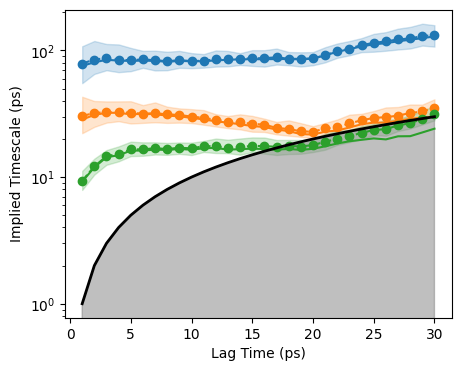

In [8]:
from deeptime.plots.util import default_colors
from deeptime.util import confidence_interval

fig, ax = plt.subplots(figsize=(5,4))

colors = default_colors()

for i in range(n_its):
    color = colors[i % len(colors)]
    ax.plot(its_data.lagtimes * ps_per_step, its_data.timescales_for_process(i) * ps_per_step,color=color)
    its_samples = its_data.samples_for_process(i)
    sample_mean = np.nanmean(its_samples, axis=1)
    ax.plot(its_data.lagtimes * ps_per_step, sample_mean * ps_per_step, marker='o', linestyle='dashed',color=color)
    l_conf, r_conf = confidence_interval(its_samples.T, conf=0.95, remove_nans=True)
    ax.fill_between(its_data.lagtimes * ps_per_step, l_conf * ps_per_step, r_conf * ps_per_step, alpha=0.2,color=color)
    
ax.plot(its_data.lagtimes * ps_per_step, its_data.lagtimes * ps_per_step, linewidth=2, color='black')
ax.fill_between(its_data.lagtimes * ps_per_step, np.full((its_data.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data.lagtimes * ps_per_step,
                alpha=0.5, color='grey')

ax.set_yscale('log')
ax.set_xlabel('Lag Time (ps)')
ax.set_ylabel('Implied Timescale (ps)')

plt.savefig('figures/adaptive_its.png',dpi=600)

In [9]:
confidences_pred_l = []
confidences_pred_r = []

conf = 0.95

samples = ck_test.predictions_samples

any_complex = np.any(~np.isreal(ck_test.estimates)) or np.any(~np.isreal(ck_test.predictions))

confidences_est_l = []
confidences_est_r = []
confidences_pred_l = []
confidences_pred_r = []

if ck_test.has_errors:
    samples = ck_test.predictions_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_pred, r_pred = confidence_interval(np.real(lag_samples) if not any_complex
                                             else [x.real for x in lag_samples],
                                             conf=conf, remove_nans=True)
        confidences_pred_l.append(l_pred)
        confidences_pred_r.append(r_pred)

    samples = ck_test.estimates_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_est, r_est = confidence_interval(np.real(lag_samples) if not any_complex
                                           else [x.real for x in lag_samples],
                                           conf=conf, remove_nans=True)
        confidences_est_l.append(l_est)
        confidences_est_r.append(r_est)

if any_complex:
    warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",
                  category=np.ComplexWarning)

confidences = [confidences_est_l, confidences_est_r, confidences_pred_l, confidences_pred_r]
confidences = [np.array(conf) for conf in confidences]
l_est, r_est, l_pred, r_pred = confidences

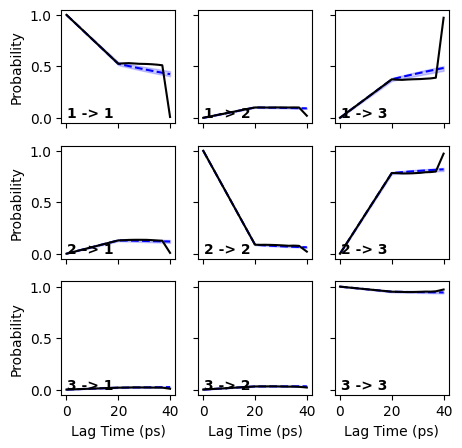

In [10]:
# cktest plot
fig,ax = plt.subplots(nrows=ck_test.n_components,ncols=ck_test.n_components,sharex=True,sharey=True,figsize=(5,5))
for i in range(ck_test.n_components):
    for j in range(ck_test.n_components):
        ax[i,j].plot(ck_test.lagtimes * ps_per_step, ck_test.predictions[:,i,j],color='blue',linestyle='dashed')
        ax[i,j].plot(ck_test.lagtimes * ps_per_step, ck_test.estimates[:,i,j],color='black')
        ax[i,j].fill_between(ck_test.lagtimes * ps_per_step , l_pred[:, i, j].real, r_pred[:, i, j].real, color='blue', alpha=0.2)
        #ax[i,j].set_xlim((ck_test.lagtimes * ns_per_step).min(),(ck_test.lagtimes * ns_per_step).max())
        #ax[i,j].set_ylim(0,1)
        if i == 2:
            ax[i,j].set_xlabel('Lag Time (ps)')
        if j == 0:
            ax[i,j].set_ylabel('Probability')
        ax[i,j].text(0.05, 0.05, str(i + 1) + ' -> ' + str(j + 1), transform=ax[i,j].transAxes, weight='bold')
        ax[i,j].set_xticks([0,20,40])

plt.savefig('figures/adaptive-cktest.png',dpi=600)

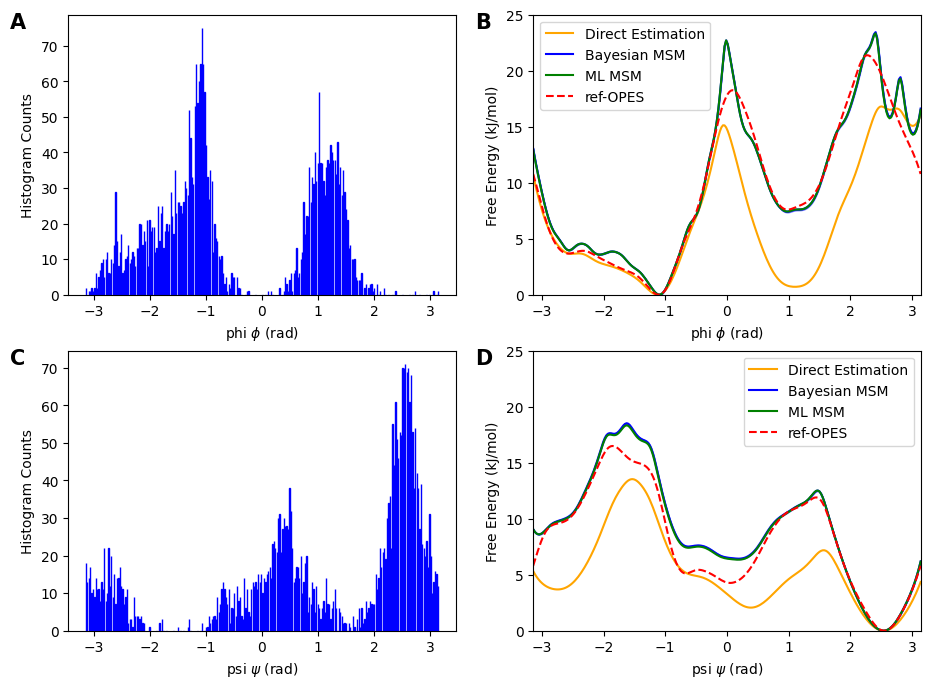

In [11]:
from scipy.stats import gaussian_kde
index_x = -0.15
index_y = 0.95

sigma = 0.1
temperature = 310
x_grid = np.linspace(-3.142,3.142,250)

msm_lagtime = 20

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(11,8))

### Phi
# plot density first
histogram_count, edge = np.histogram(ref_data['phi'],250)
density = histogram_count / histogram_count.sum()
ax[0,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[0,0].set_xlabel('phi $\phi$ (rad)')
ax[0,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data['phi'],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[0,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data['phi'],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data['phi'],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[0,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[0,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[0,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
fes_ref_phi = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes-phi.dat')
#fes_ref_phi_err = np.loadtxt('opes/COLVAR/block_15_err/err_fes_phi_15')

ax[0,1].plot(fes_ref_phi['phi'],fes_ref_phi['file.free'],'r--',label='ref-OPES')
#ax[0,1].fill_between(fes_ref_phi['phi'],fes_ref_phi['file.free']-fes_ref_phi_err,fes_ref_phi['file.free']+fes_ref_phi_err,alpha=0.5,color='red')

ax[0,1].set_ylim(0,25)
ax[0,1].set_xlim(-3.142,3.142)
ax[0,1].set_xlabel('phi $\phi$ (rad)')
ax[0,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,1].legend()

### Psi
# plot density first
histogram_count, edge = np.histogram(ref_data['psi'],250)
density = histogram_count / histogram_count.sum()
ax[1,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[1,0].set_xlabel('psi $\psi$ (rad)')
ax[1,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data['psi'],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[1,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data['psi'],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data['psi'],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[1,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[1,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[1,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
fes_ref_phi = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes-psi.dat')
ax[1,1].plot(fes_ref_phi['psi'],fes_ref_phi['file.free'],'r--',label='ref-OPES')

ax[1,1].set_ylim(0,25)
ax[1,1].set_xlim(-3.142,3.142)
ax[1,1].set_xlabel('psi $\psi$ (rad)')
ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[1,1].legend()

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')

plt.savefig('figures/adaptive_sampling_FES.png',dpi=600)

plt.show()

##### 51.2ns Adaptive Sampling using 10x longer trajectories

In [12]:
colvar = '../8-adaptive-400ps/CV/COLVAR'
n_sim = 16
sim_idx = 8

traj,data = read_features(colvar,sim_idx,n_sim)

round_seed_idx = []

for i in range(1,sim_idx):
    round_seed_idx_i = np.loadtxt('../8-adaptive-400ps/round{i}_seed.txt'.format(i=i),dtype=int)
    round_seed_idx.append(round_seed_idx_i)

round_seed_idx = np.concatenate(round_seed_idx)

data_supp = []        # We did not apply data supplementation when using the common adaptive sampling + MSM pipeline

In [13]:
# final ktica
tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

In [14]:
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('../8-adaptive-400ps/CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

In [15]:
ref_data.shape

(51328, 3)

In [16]:
n_microstates = 50

assignments,assignments_concat,cluster_centers,assignments_supp = run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs)

In [17]:
# Markov State Model Validation
n_its = 3
its_lagtimes = [1,2,4,8,12,16,20,25,30,35,40,45,50,60,70,80,90,100]

msm_lagtime = 20

converged_its = 100
n_space = 10
n_metastable_sets = 4

ps_per_step = 1

# ITS
models = []
for lagtime in its_lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
its_data = implied_timescales(models)


# MSM
counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)

# cktest
models = []
lagtimes = np.linspace(msm_lagtime,converged_its,n_space,dtype=int)
for lagtime in lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
ck_test = msm.ck_test(models,n_metastable_sets=n_metastable_sets)

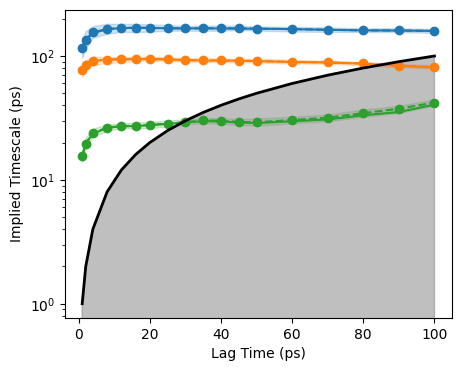

In [18]:
from deeptime.plots.util import default_colors
from deeptime.util import confidence_interval

fig, ax = plt.subplots(figsize=(5,4))

colors = default_colors()

for i in range(n_its):
    color = colors[i % len(colors)]
    ax.plot(its_data.lagtimes * ps_per_step, its_data.timescales_for_process(i) * ps_per_step,color=color)
    its_samples = its_data.samples_for_process(i)
    sample_mean = np.nanmean(its_samples, axis=1)
    ax.plot(its_data.lagtimes * ps_per_step, sample_mean * ps_per_step, marker='o', linestyle='dashed',color=color)
    l_conf, r_conf = confidence_interval(its_samples.T, conf=0.95, remove_nans=True)
    ax.fill_between(its_data.lagtimes * ps_per_step, l_conf * ps_per_step, r_conf * ps_per_step, alpha=0.2,color=color)
    
ax.plot(its_data.lagtimes * ps_per_step, its_data.lagtimes * ps_per_step, linewidth=2, color='black')
ax.fill_between(its_data.lagtimes * ps_per_step, np.full((its_data.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data.lagtimes * ps_per_step,
                alpha=0.5, color='grey')

ax.set_yscale('log')
ax.set_xlabel('Lag Time (ps)')
ax.set_ylabel('Implied Timescale (ps)')

plt.savefig('figures/adaptive_its400ps.png',dpi=600)

In [19]:
confidences_pred_l = []
confidences_pred_r = []

conf = 0.95

samples = ck_test.predictions_samples

any_complex = np.any(~np.isreal(ck_test.estimates)) or np.any(~np.isreal(ck_test.predictions))

confidences_est_l = []
confidences_est_r = []
confidences_pred_l = []
confidences_pred_r = []

if ck_test.has_errors:
    samples = ck_test.predictions_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_pred, r_pred = confidence_interval(np.real(lag_samples) if not any_complex
                                             else [x.real for x in lag_samples],
                                             conf=conf, remove_nans=True)
        confidences_pred_l.append(l_pred)
        confidences_pred_r.append(r_pred)

    samples = ck_test.estimates_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_est, r_est = confidence_interval(np.real(lag_samples) if not any_complex
                                           else [x.real for x in lag_samples],
                                           conf=conf, remove_nans=True)
        confidences_est_l.append(l_est)
        confidences_est_r.append(r_est)

if any_complex:
    warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",
                  category=np.ComplexWarning)

confidences = [confidences_est_l, confidences_est_r, confidences_pred_l, confidences_pred_r]
confidences = [np.array(conf) for conf in confidences]
l_est, r_est, l_pred, r_pred = confidences

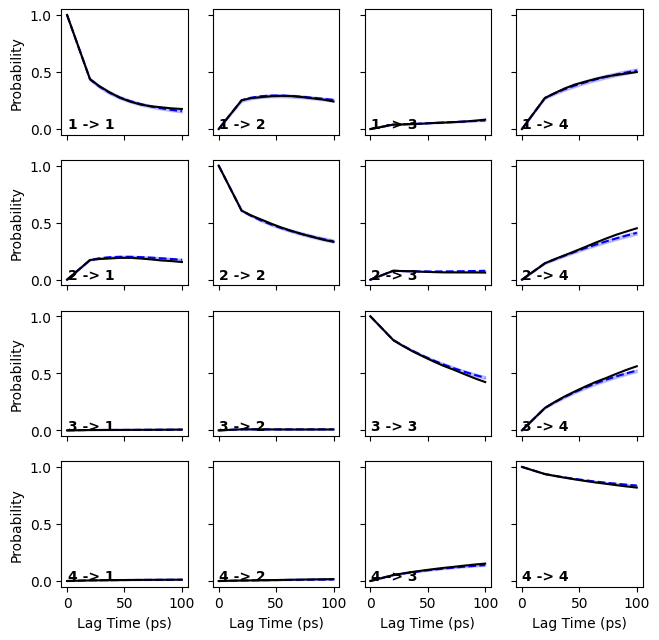

In [20]:
# cktest plot
fig,ax = plt.subplots(nrows=ck_test.n_components,ncols=ck_test.n_components,sharex=True,sharey=True,figsize=(7.5,7.5))
for i in range(ck_test.n_components):
    for j in range(ck_test.n_components):
        ax[i,j].plot(ck_test.lagtimes * ps_per_step, ck_test.predictions[:,i,j],color='blue',linestyle='dashed')
        ax[i,j].plot(ck_test.lagtimes * ps_per_step, ck_test.estimates[:,i,j],color='black')
        ax[i,j].fill_between(ck_test.lagtimes * ps_per_step , l_pred[:, i, j].real, r_pred[:, i, j].real, color='blue', alpha=0.2)
        #ax[i,j].set_xlim((ck_test.lagtimes * ns_per_step).min(),(ck_test.lagtimes * ns_per_step).max())
        #ax[i,j].set_ylim(0,1)
        if i == 3:
            ax[i,j].set_xlabel('Lag Time (ps)')
        if j == 0:
            ax[i,j].set_ylabel('Probability')
        ax[i,j].text(0.05, 0.05, str(i + 1) + ' -> ' + str(j + 1), transform=ax[i,j].transAxes, weight='bold')

plt.savefig('figures/adaptive-cktest400ps.png',dpi=600)

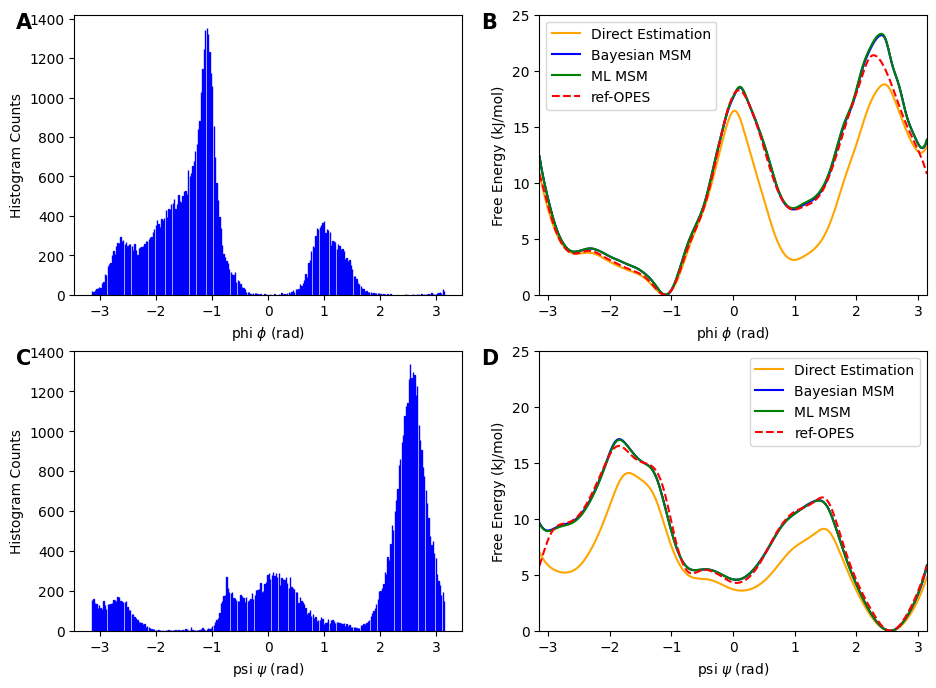

In [21]:
from scipy.stats import gaussian_kde
index_x = -0.15
index_y = 0.95

sigma = 0.1
temperature = 310
x_grid = np.linspace(-3.142,3.142,250)

msm_lagtime = 20

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(11,8))

### Phi
# plot density first
histogram_count, edge = np.histogram(ref_data['phi'],250)
density = histogram_count / histogram_count.sum()
ax[0,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[0,0].set_xlabel('phi $\phi$ (rad)')
ax[0,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data['phi'],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[0,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data['phi'],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data['phi'],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[0,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[0,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[0,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
fes_ref_phi = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes-phi.dat')
#fes_ref_phi_err = np.loadtxt('opes/COLVAR/block_15_err/err_fes_phi_15')

ax[0,1].plot(fes_ref_phi['phi'],fes_ref_phi['file.free'],'r--',label='ref-OPES')
#ax[0,1].fill_between(fes_ref_phi['phi'],fes_ref_phi['file.free']-fes_ref_phi_err,fes_ref_phi['file.free']+fes_ref_phi_err,alpha=0.5,color='red')

ax[0,1].set_ylim(0,25)
ax[0,1].set_xlim(-3.142,3.142)
ax[0,1].set_xlabel('phi $\phi$ (rad)')
ax[0,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,1].legend()

### Psi
# plot density first
histogram_count, edge = np.histogram(ref_data['psi'],250)
density = histogram_count / histogram_count.sum()
ax[1,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[1,0].set_xlabel('psi $\psi$ (rad)')
ax[1,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data['psi'],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[1,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data['psi'],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data['psi'],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[1,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[1,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[1,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
fes_ref_phi = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes-psi.dat')
ax[1,1].plot(fes_ref_phi['psi'],fes_ref_phi['file.free'],'r--',label='ref-OPES')

ax[1,1].set_ylim(0,25)
ax[1,1].set_xlim(-3.142,3.142)
ax[1,1].set_xlabel('psi $\psi$ (rad)')
ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[1,1].legend()

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')

plt.savefig('figures/adaptive_sampling_FES400ps.png',dpi=600)

plt.show()